In [30]:

import pickle as p
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib as mplt

from sunraster.instr.spice import read_spice_l2_fits
from spice_utils.ias_spice_utils import utils as spu 

from SlimPy.init_handler import getfiles,get_celestial
from SlimPy.visualization import _plot_window_Miho
from SlimPy.fit_models import flat_inArg_multiGauss 
from SlimPy.utils import fst_neigbors,join_dt,gen_velocity

class SPICE_raster():
    def __init__(self):
        self.L2_data = None
        self.L3_data = None
        self.meta    = None
        self.lon     = None
        self.lat     = None
        self.unq     = None
        self.model   = flat_inArg_multiGauss
        self.conv_data = None
        self.convolution_extent_list = None
        self.quiet_sun = np.array([[0,-1],[0,-1]])
     
    def charge_data(self, L3_PathOrRaster,L2_PathOrRaster=None):
        self.L3_data = p.load(open(L3_PathOrRaster,"rb"))
        meta = self.L3_data[4] if type(self.L3_data[4]) != list else self.L3_data[4][0]
        
        if type(L2_PathOrRaster) == type(None):    
            date     = self.L3_data[4][0]["DATE-OBS"]
            year     = date[0:4]
            month    = date[5:7]
            day      = date[8:10]
            hour     = date[11:13]
            minute   = date[14:16]
            seond    = date[17:19]
            str_date = year +month +day +"T"+hour +minute +seond
            print(year,month,day)
            selected_date = getfiles(YEAR=int(year),
                                    MONTH=int(month),
                                    DAY=int(day),
                                    STD_TYP="ALL",
                                    verbose = 0)
            selected_file = []
            for file in selected_date:
                if str_date in str(file):
                    selected_file.append(file)
            if len(selected_file)>1: raise ValueError(f'found more than 1 selected file {selected_file}')
            L2_PathOrRaster = selected_file[0]
        self.L2_data = read_spice_l2_fits(str(L2_PathOrRaster))
        self.lon, self.lat = get_celestial(self.L2_data)
        self.unq = spu.unique_windows(self.L2_data)
        
        if True: #convlist handeling
            convolution_function = lambda lst:np.zeros_like(lst[:,2])+1
            lat_pixel_size= abs(np.nanmean(self.lat[1:,:]-self.lat[:-1,:]))
            lon_pixel_size= abs(np.nanmean(self.lon[:,1:]-self.lat[:,:-1]))
            convolution_extent_list = np.unique(self.L3_data[3])
            convolution_extent_list = convolution_extent_list[np.logical_not(np.isnan(convolution_extent_list))]
            self.convolution_extent_list = convolution_extent_list
            self.conv_data = []

            for j,kw in enumerate(self.unq):
                conv_data = np.zeros((*convolution_extent_list.shape,*self.L2_data[self.unq[j]].data.shape))
                for i in range(convolution_extent_list.shape[0]):
                    if convolution_extent_list[i] == 0:
                        conv_data[i]=self.L2_data[self.unq[j]].data.copy();continue
                    else:
                        ijc_list = np.array(fst_neigbors(convolution_extent_list[i],lon_pixel_size,lat_pixel_size)).astype(int)
                        ijc_list [:,2]= convolution_function(ijc_list)
                        conv_data[i]  = join_dt((self.L2_data[self.unq[j]].data).astype(float), ijc_list)
                self.conv_data.append(conv_data.copy())
    
    def get_velocity(self,kwOri=0,ion_order=0,quiet_sun=None):
        kw = kwOri if type(kwOri) == str else self.unq[kwOri] 
        i  = kwOri if type(kwOri) == int else (self.unq).index(kwOri) 
        if type(quiet_sun)==type(None) : quiet_sun = self.quiet_sun
        
        wvl_data = self.L3_data[0][i][ion_order*3+1][0]
        if quiet_sun[0,1] < 0: quiet_sun[0,1] = (wvl_data.shape[0])+quiet_sun[0,1]
        if quiet_sun[1,1] < 0: quiet_sun[1,1] = (wvl_data.shape[1])+quiet_sun[1,1]
        print([quiet_sun[1,0],quiet_sun[1,1],quiet_sun[0,0],quiet_sun[0,1]])
        res = gen_velocity(wvl_data,np.array([quiet_sun[1,0],quiet_sun[1,1],quiet_sun[0,0],quiet_sun[0,1]]),correction=True)
        # plt.figure()
        # plt.pcolormesh(res[0],vmin=-40,vmax=40,cmap="seismic")
        # plt.figure()
        # plt.hist(res[0])
        return res[0]
    
    def apply_conditions(self,kwOri,conditions,quiet_sun = None):
        kw = kwOri if type(kwOri) == str else self.unq[kwOri] 
        i  = kwOri if type(kwOri) == int else (self.unq).index(kwOri) 
        paramlist = self.L3_data[0][i].copy()
        
        for mode in conditions:
            if "min_I" in mode:
                if ' s' in mode or ' all' in mode:
                    paramlist[2:-1:3][paramlist[0:-1:3]<conditions[mode]] = np.nan 
                if ' x' in mode or ' all' in mode:
                    paramlist[1:-1:3][paramlist[0:-1:3]<conditions[mode]] = np.nan 
                if ' I' in mode or ' all' in mode:
                    paramlist[0:-1:3][paramlist[0:-1:3]<conditions[mode]] = np.nan 
            elif "max_v" in mode:
                #get_velocity_first
                ion_order = mode.find("ion")+4
                if ion_order not in ["all","ALL"]:ion_order = int(ion_order)
                if type(ion_order) == int:
                    ion_indices = [ ion_order  for i in range(paramlist.shape[0])]
                elif type(ion_order) == str:
                    if ion_order in ["all","ALL"]:
                        ion_indices = [ i  for i in range(paramlist.shape[0])]
                    else: raise ValueError(f"{ion_order} not understood")                
                else: raise ValueError(f"{ion_order} not understood")
                
                for i_ind in range(paramlist.shape[0]//3):
                    velocity_data = self.get_velocity(kwOri=kwOri,
                                                      ion_order=i_ind,
                                                      quiet_sun=quiet_sun)
                                                                                  
                    if ' s' in mode or ' all' in mode:
                        paramlist[i_ind*3+2][0][(np.abs(velocity_data))>conditions[mode]] = np.nan 
                    if ' x' in mode or ' all' in mode:
                        paramlist[i_ind*3+1][0][(np.abs(velocity_data))>conditions[mode]] = np.nan 
                    if ' I' in mode or ' all' in mode:
                        paramlist[i_ind*3+0][0][(np.abs(velocity_data))>conditions[mode]] = np.nan 
                                    
            else: raise ValueError(f"{mode} not understood")    
        return paramlist 
       
    def plot_window(self,kwOri,conditions={},quiet_sun=None):
        kw = kwOri if type(kwOri) == str else self.unq[kwOri] 
        i  = kwOri if type(kwOri) == int else (self.unq).index(kwOri) 
        
        window = (self.L2_data[kw].data).astype(float).copy()
        paramlist = self.L3_data[0][i].copy()
        paramlist = self.apply_conditions(kwOri=kwOri,conditions=conditions,quiet_sun=quiet_sun).copy()
        for _i,params in enumerate(paramlist):
            if np.isnan(params).all():
                print(f"found NaNed list in {_i}")
                
        _plot_window_Miho(
                spectrum_axis = (self.L2_data[kw].spectral_axis *10**10).astype(float),                    
                window        =  window,           
                paramlist     =  paramlist,
                quentity      =  self.L3_data[2][i],
                convlist      =  self.L3_data[3][i],
                raster        =  self.L2_data[kw],
                suptitle      =  kw,
                quite_sun     = ([quiet_sun[1,0],quiet_sun[1,1],quiet_sun[0,0],quiet_sun[0,1]]) if type(quiet_sun)!=type(None) else np.array([0,-1,0,-1]),
                visualize_saturation=True)
    
    def plot_all_windows(self,conditions={},quiet_sun=None):
        for i,kw in enumerate(self.unq):
            self.plot_window(kwOri=kw,conditions=conditions,quiet_sun=quiet_sun)
            
    def _get_random_positions(self,number,window_size = np.array([[0,-1],[0,-1]])):
        data_shape = self.L2_data[self.unq[0]].data.shape
        if window_size[0,1] < 0 :window_size[0,1] = data_shape[2] + window_size[0,1] 
        if window_size[1,1] < 0 :window_size[1,1] = data_shape[3] + window_size[1,1]
        random_positions = []
        while True:
            rand_y = np.random.randint(*window_size[0])
            rand_x = np.random.randint(*window_size[1])
            if [rand_y, rand_x] not in random_positions: random_positions.append([rand_y, rand_x]) 
            if len(random_positions) >= number: break
        return np.array(random_positions)
        
    def plot_selected_pixels(self,
                             positions_list,
                             kwOri = 0,
                             fig_axis=None):
        kw = kwOri if type(kwOri) == str else self.unq[kwOri] 
        i  = kwOri if type(kwOri) == int else (self.unq).index(kwOri) 
        number = len(positions_list)
        if type(fig_axis)==type(None):
            ratio = 3
            n = int(np.sqrt(number))
            m = int(number//n) + (1 if number%n!=0 else 0)
            params = {
                    'legend.fontsize': 10*ratio/4,
                    # 'figure.figsize': (15, 5),
                    'axes.labelsize':  10*ratio/2 ,
                    'axes.titlesize':  10*ratio/2 ,
                    'xtick.labelsize': 10*ratio/2 ,
                    'ytick.labelsize': 10*ratio/2 ,
                    'lines.linewidth':0.5*ratio
                    }
            plt.rcParams.update(params)

            fig,axis  = plt.subplots(n,m,figsize=(ratio*m,ratio*n),sharex=True)
            axis = axis.flatten()
        else:
            fig,axis = fig_axis
        specaxis = (self.L2_data[kw].spectral_axis*10**10).astype(float)
        for j,indices in enumerate(positions_list):
            specdata = (self.L2_data[kw].data[0,:,indices[0],indices[1]]).astype(float)
            params = self.L3_data[0][i][:,0,indices[0],indices[1]]
            conv_level = self.L3_data[3][i][0,indices[0],indices[1]]
            axis[j].step(specaxis,specdata, label="raw")
            axis[j].plot(specaxis,self.model(specaxis,*params),label="fit{}".format("(lost)" if np.isnan(params).any() else ""))
            if conv_level!=0:
                for k,conv_ind in enumerate(self.convolution_extent_list):
                    if conv_ind == 0: continue
                    axis[j].plot(specaxis,self.conv_data[i][k][0,:,indices[0],indices[1]],
                                 label=f"conv l:{int(conv_ind):01d}")            
            axis[j].legend()  
            axis[j].set_title(f"px_x{indices[1]},px_y{indices[0]}")
        for j in range(j+1,n*m):
            axis[j].remove()
        
        plt.tight_layout()
        return fig,axis
       
    def plot_random_pixels(self, 
        number = 1, 
        fraction=None, 
        kwOri = 0,
        window_size = np.array([[0,-1],[0,-1]])
        ):
        if True:
            assert type(number) != type(None) or type(number) != type(None)
            kw = kwOri if type(kwOri) == str else self.unq[kwOri] 
            i  = kwOri if type(kwOri) == int else (self.unq).index(kwOri) 
            
            if number == type(None):
                number = fraction* self.L3_data[0][0][0][
                    np.logical_not(np.isnan(self.L3_data[0][0][0]))
                                                        ]
        random_positions = self._get_random_positions(number,window_size=window_size)
        
        fig, axis = self.plot_selected_pixels(positions_list=random_positions,
                                              kwOri=i,
                                              )
        if False:        
            
            ratio = 3
            n = int(np.sqrt(number))
            m = int(number//n) + (1 if number%n!=0 else 0)
            params = {
                    'legend.fontsize': 10*ratio/4,
                    # 'figure.figsize': (15, 5),
                    'axes.labelsize':  10*ratio/2 ,
                    'axes.titlesize':  10*ratio/2 ,
                    'xtick.labelsize': 10*ratio/2 ,
                    'ytick.labelsize': 10*ratio/2 ,
                    'lines.linewidth':0.5*ratio
                    }
            plt.rcParams.update(params)

            fig,axis  = plt.subplots(n,m,figsize=(ratio*m,ratio*n),sharex=True)
            axis = axis.flatten()
            
            specaxis = (self.L2_data[kw].spectral_axis*10**10).astype(float)
            for j,indices in enumerate(random_positions):
                specdata = (self.L2_data[kw].data[0,:,indices[0],indices[1]]).astype(float)
                params = self.L3_data[0][i][:,0,indices[0],indices[1]]
                conv_level = self.L3_data[3][i][0,indices[0],indices[1]]
                axis[j].step(specaxis,specdata, label="raw")
                axis[j].plot(specaxis,self.model(specaxis,*params),label="fit{}".format("(lost)" if np.isnan(params).any() else ""))
                if conv_level!=0:
                    for k,conv_ind in enumerate(self.convolution_extent_list):
                        if conv_ind == 0: continue
                        axis[j].plot(specaxis,self.conv_data[i][k][0,:,indices[0],indices[1]],
                                    label=f"conv l:{int(conv_ind):01d}")            
                axis[j].legend()    
            for j in range(j+1,n*m):
                axis[j].remove()
            
            plt.tight_layout()
    
    def plot_worse_plots():
        pass


In [31]:
import os 
from astropy.io import fits as fits_reader
from pathlib import Path
import numpy as np 

data = SPICE_raster()
dirs = os.listdir('./pipeline_v-00.01/')
dirs2 = []
for file in dirs:
    if "all" in file and '.p' in file:
        dirs2.append(file)
print('./pipeline_v-00.01/'+dirs2[-9])
data.charge_data('./pipeline_v-00.01/'+dirs2[-1])



./pipeline_v-00.01/solo_L2_spice-n-ras_20221011T134335_V02_150995254-000_hist_all.p
2022 10 24


keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
Set MJD-OBS to 59876.969164 from DATE-OBS.
Set MJD-BEG to 59876.969164 from DATE-BEG.
Set MJD-AVG to 59877.036108 from DATE-AVG.
Set MJD-END to 59877.103050 from DATE-END'. [astropy.wcs.wcs]


[0, 100, 120, 250]


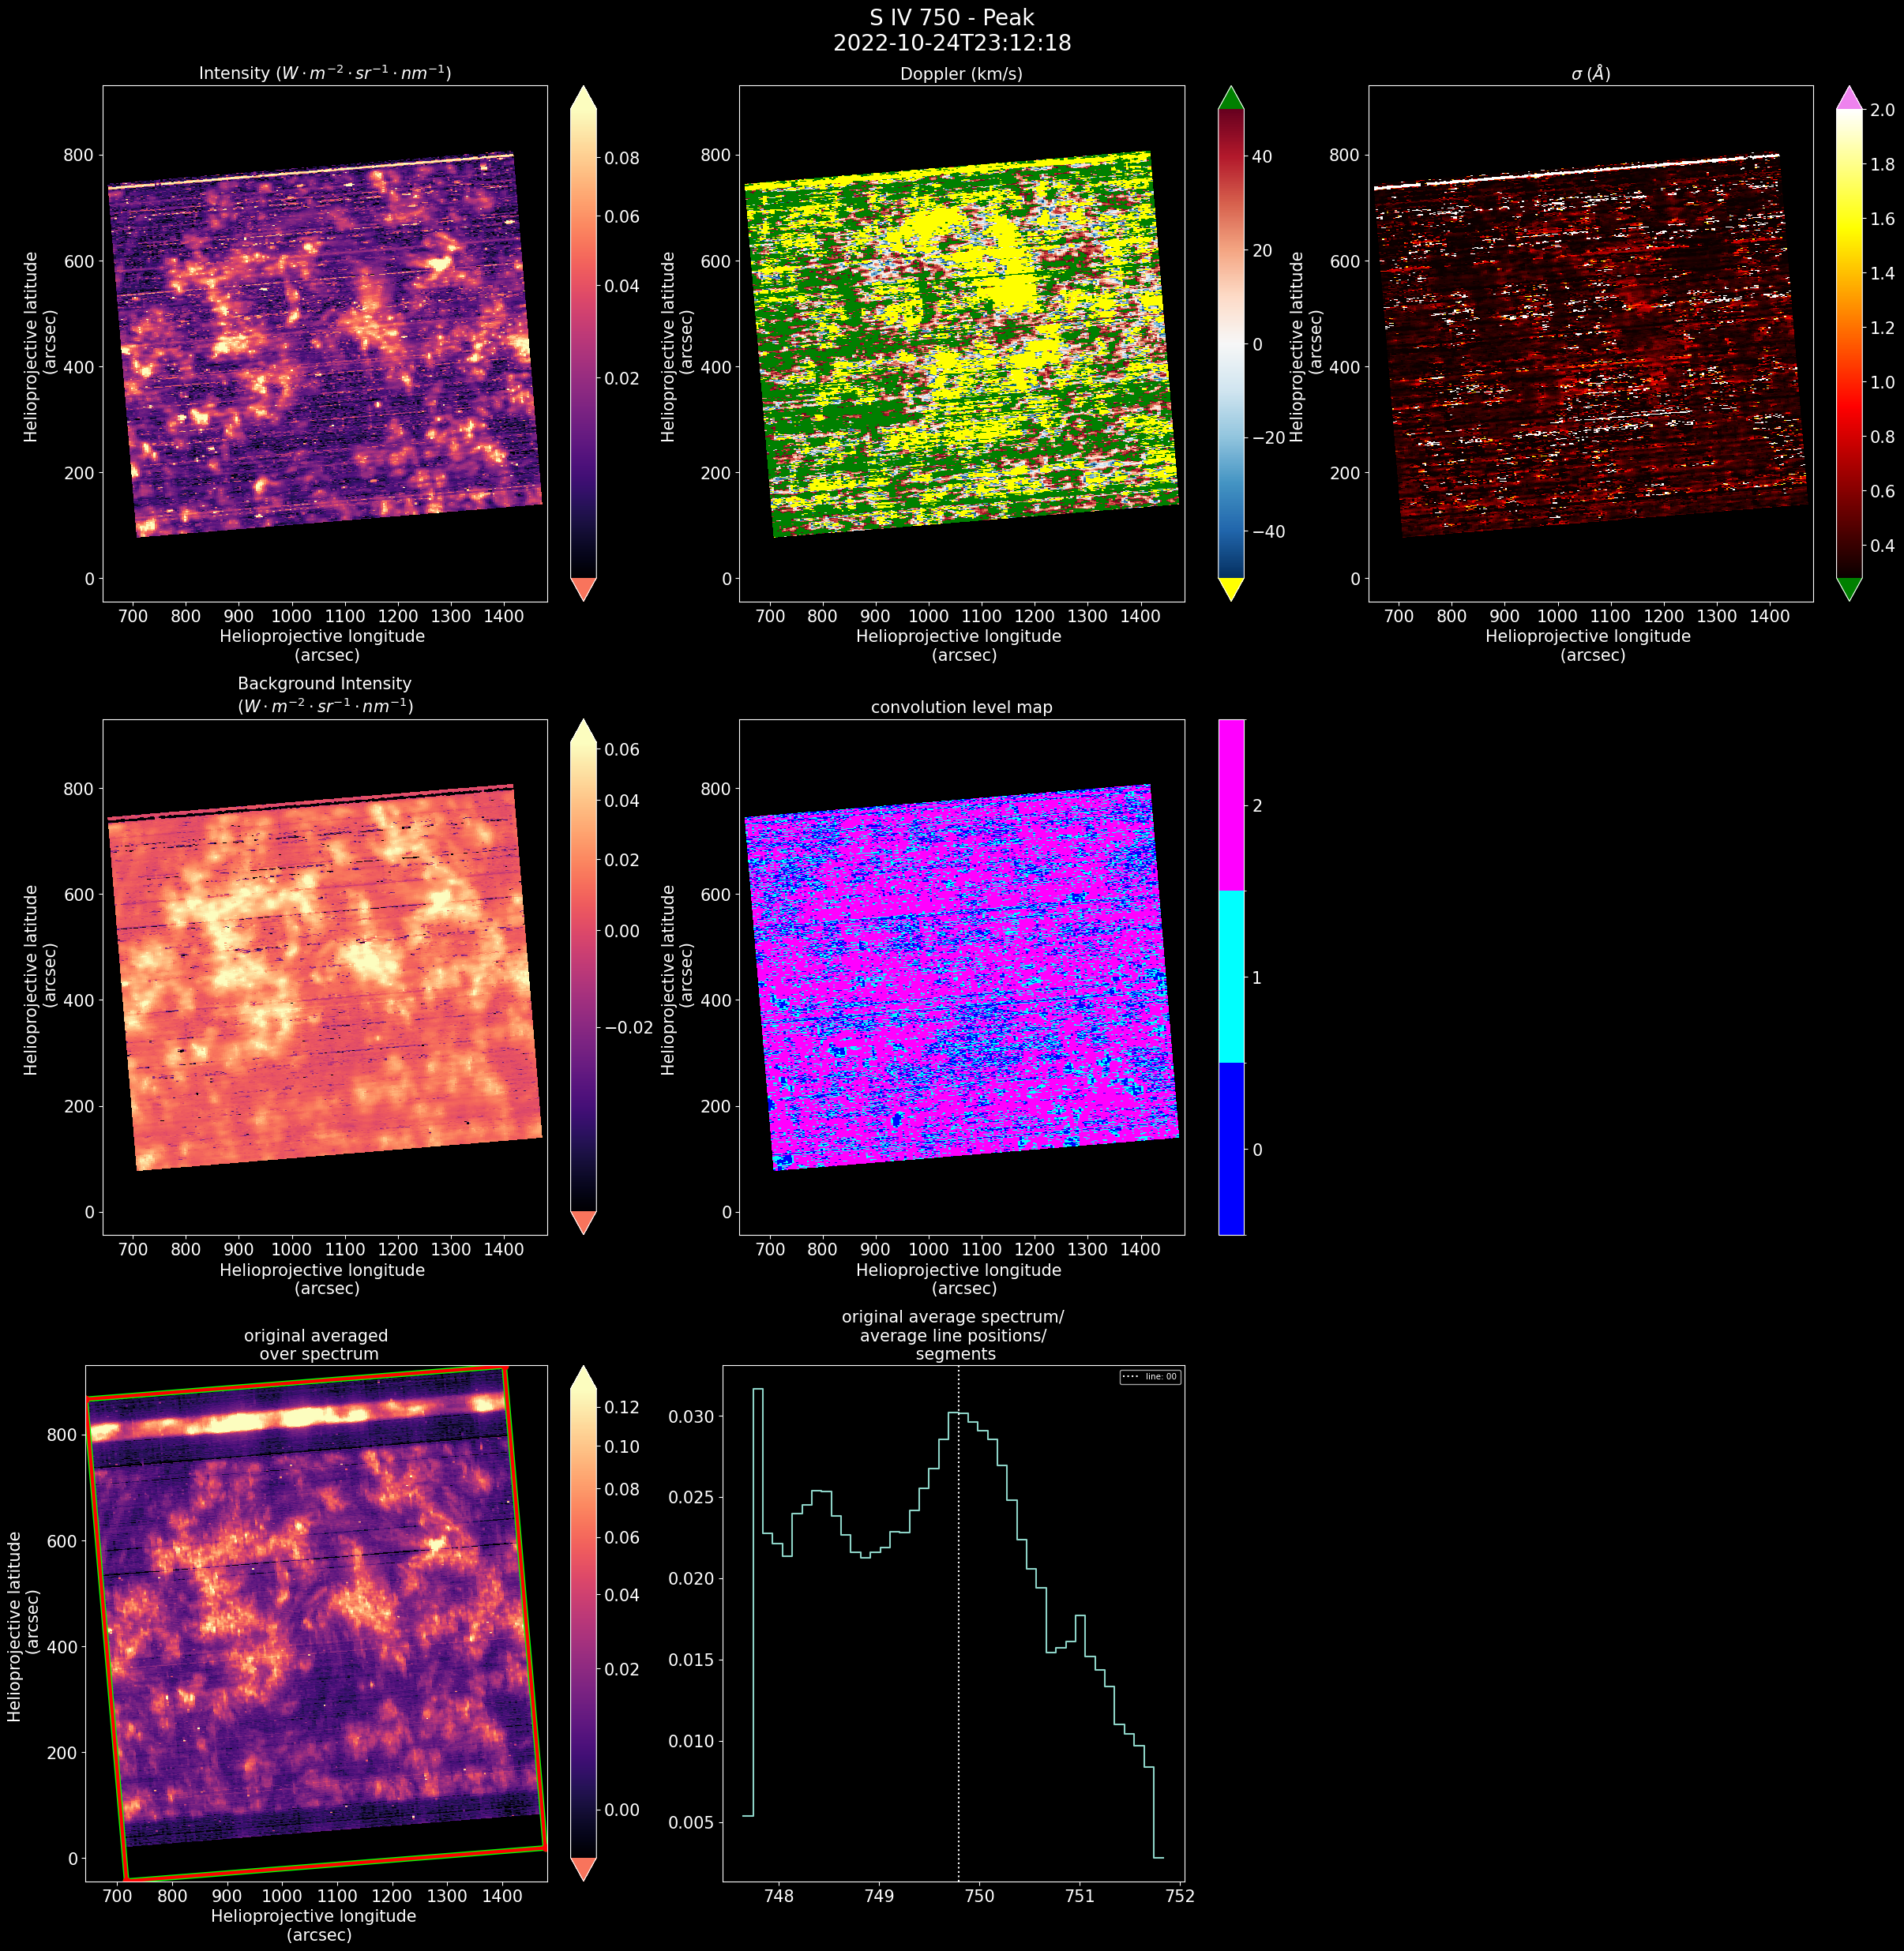

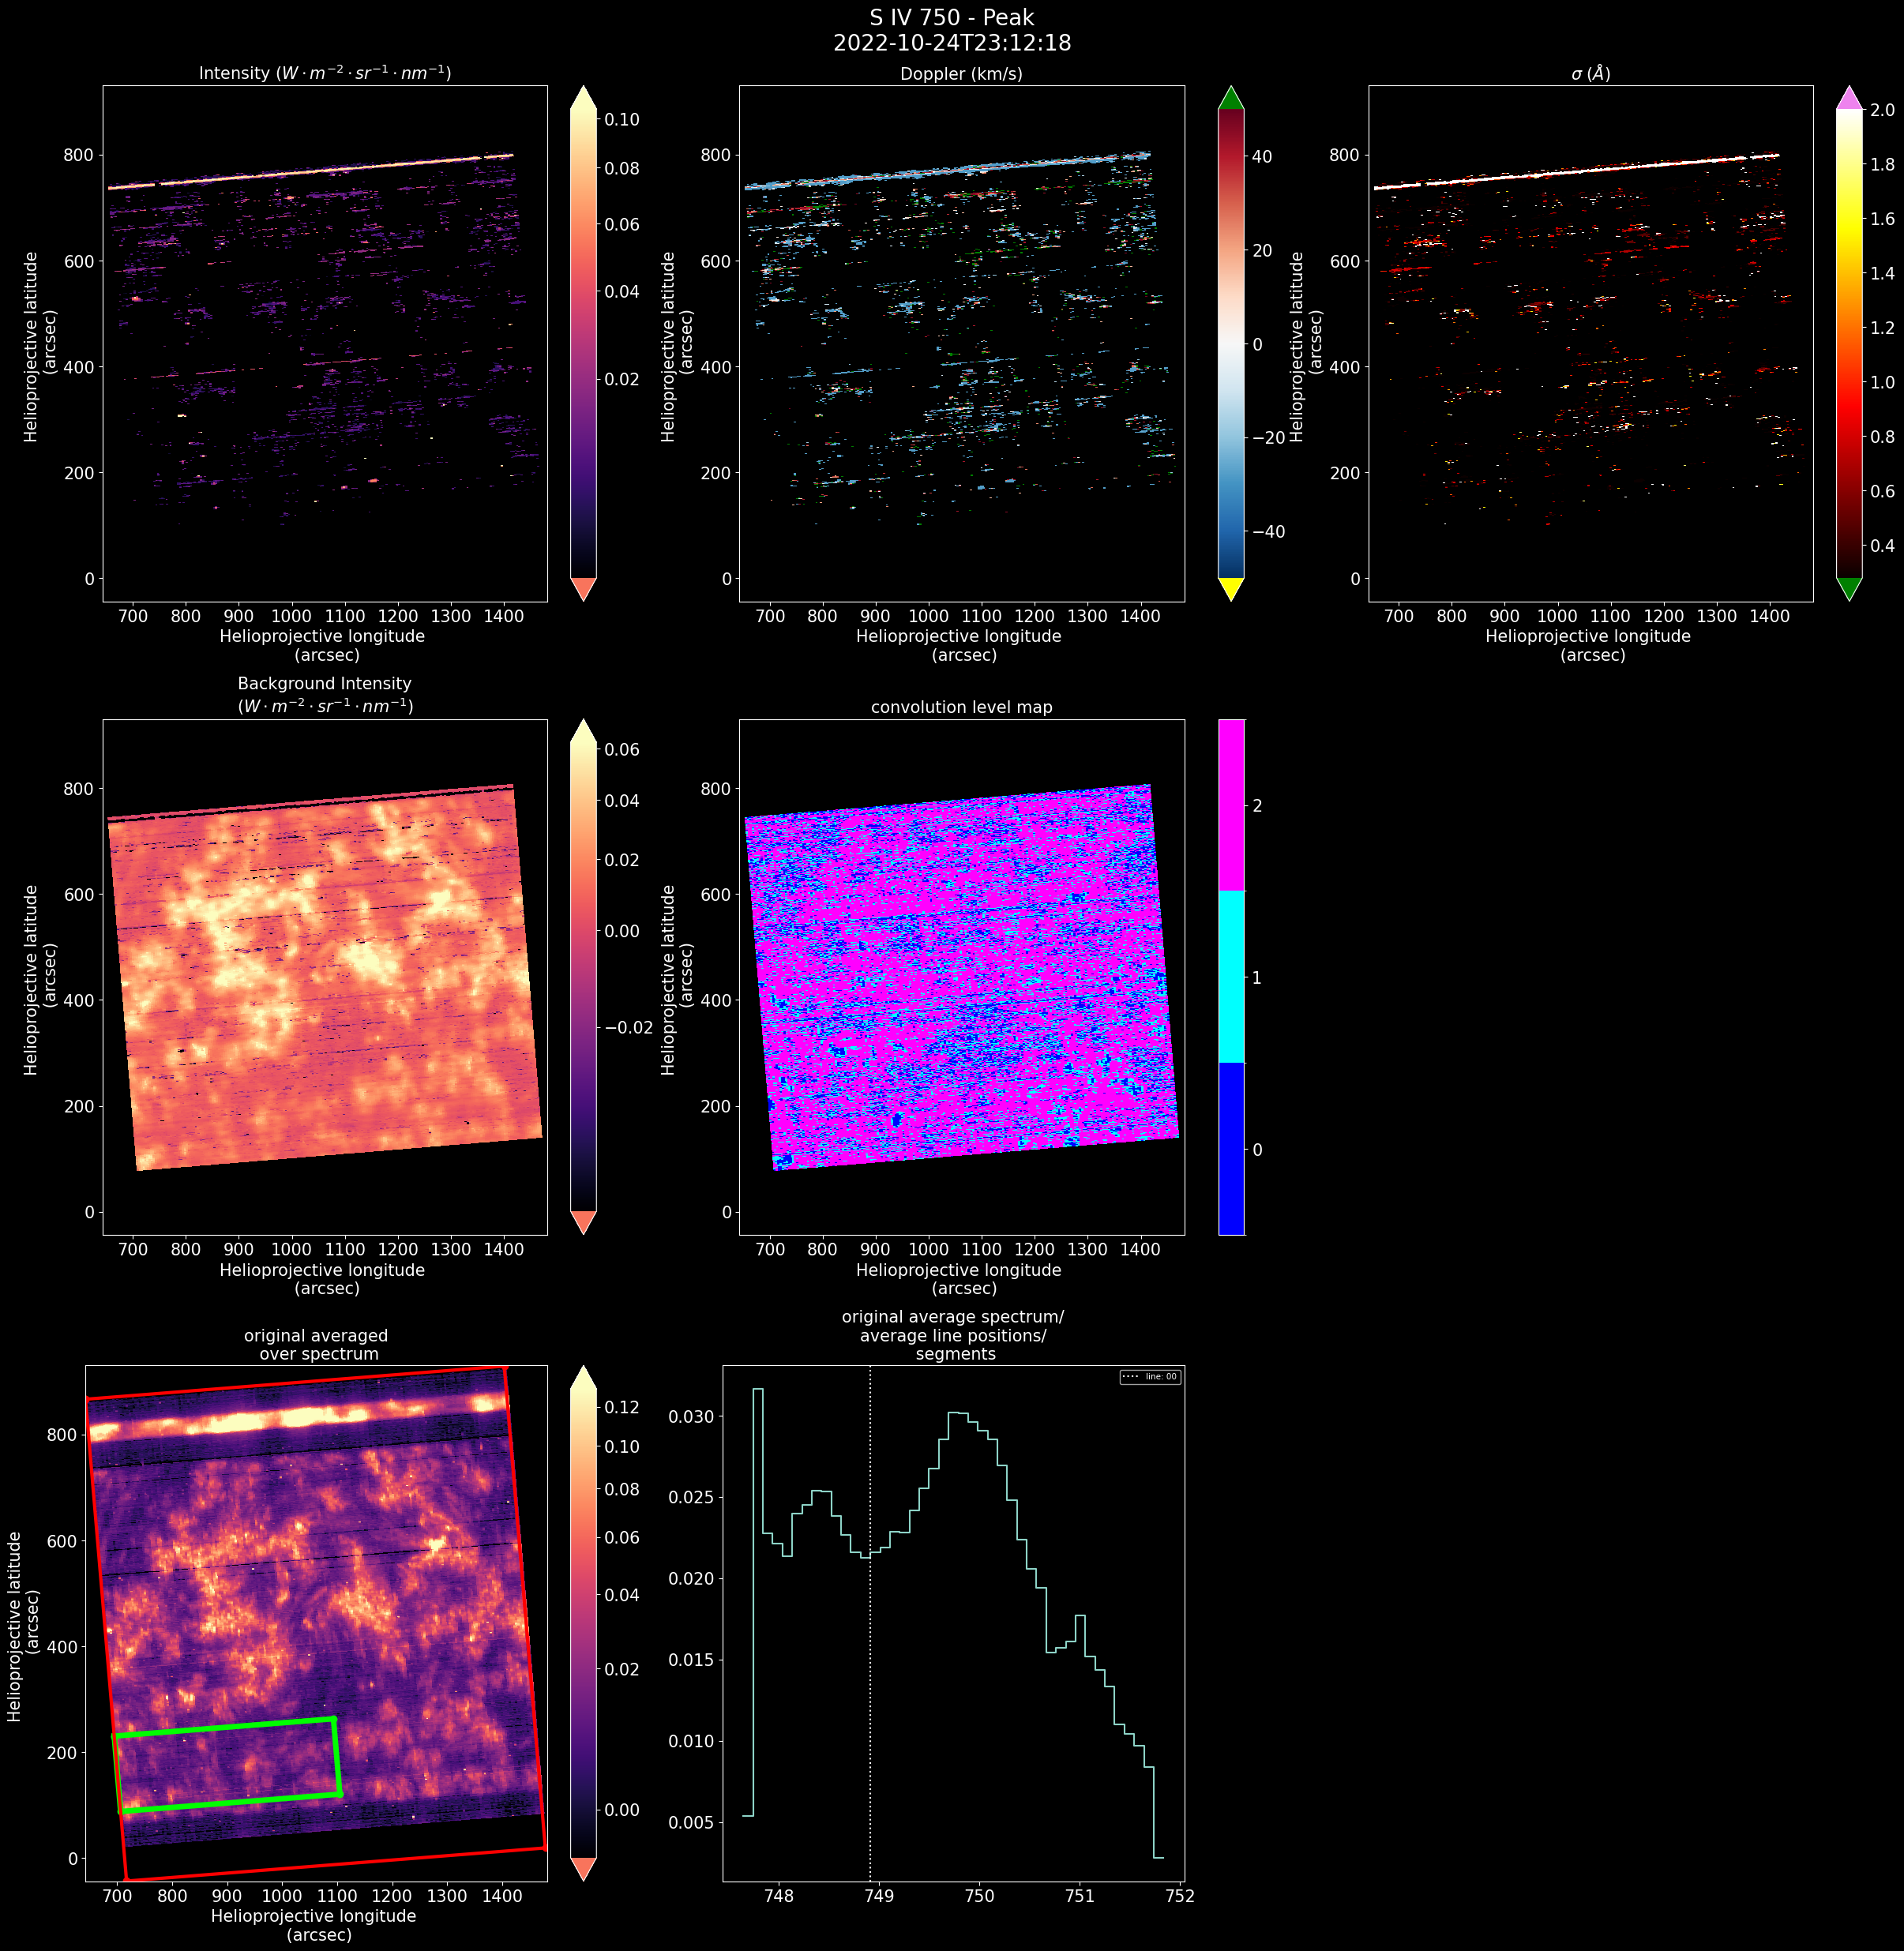

In [38]:
data.plot_window(kwOri=1,
                # conditions={"min_I on all":0.03}
                 )
data.plot_window(kwOri=1,quiet_sun=np.array([[120,250],[0,100]]),conditions={"min_I on all":0.03})
data.plot_window(kwOri=1,quiet_sun=np.array([[120,250],[0,100]]),conditions={"max_v on all ion 0":100})


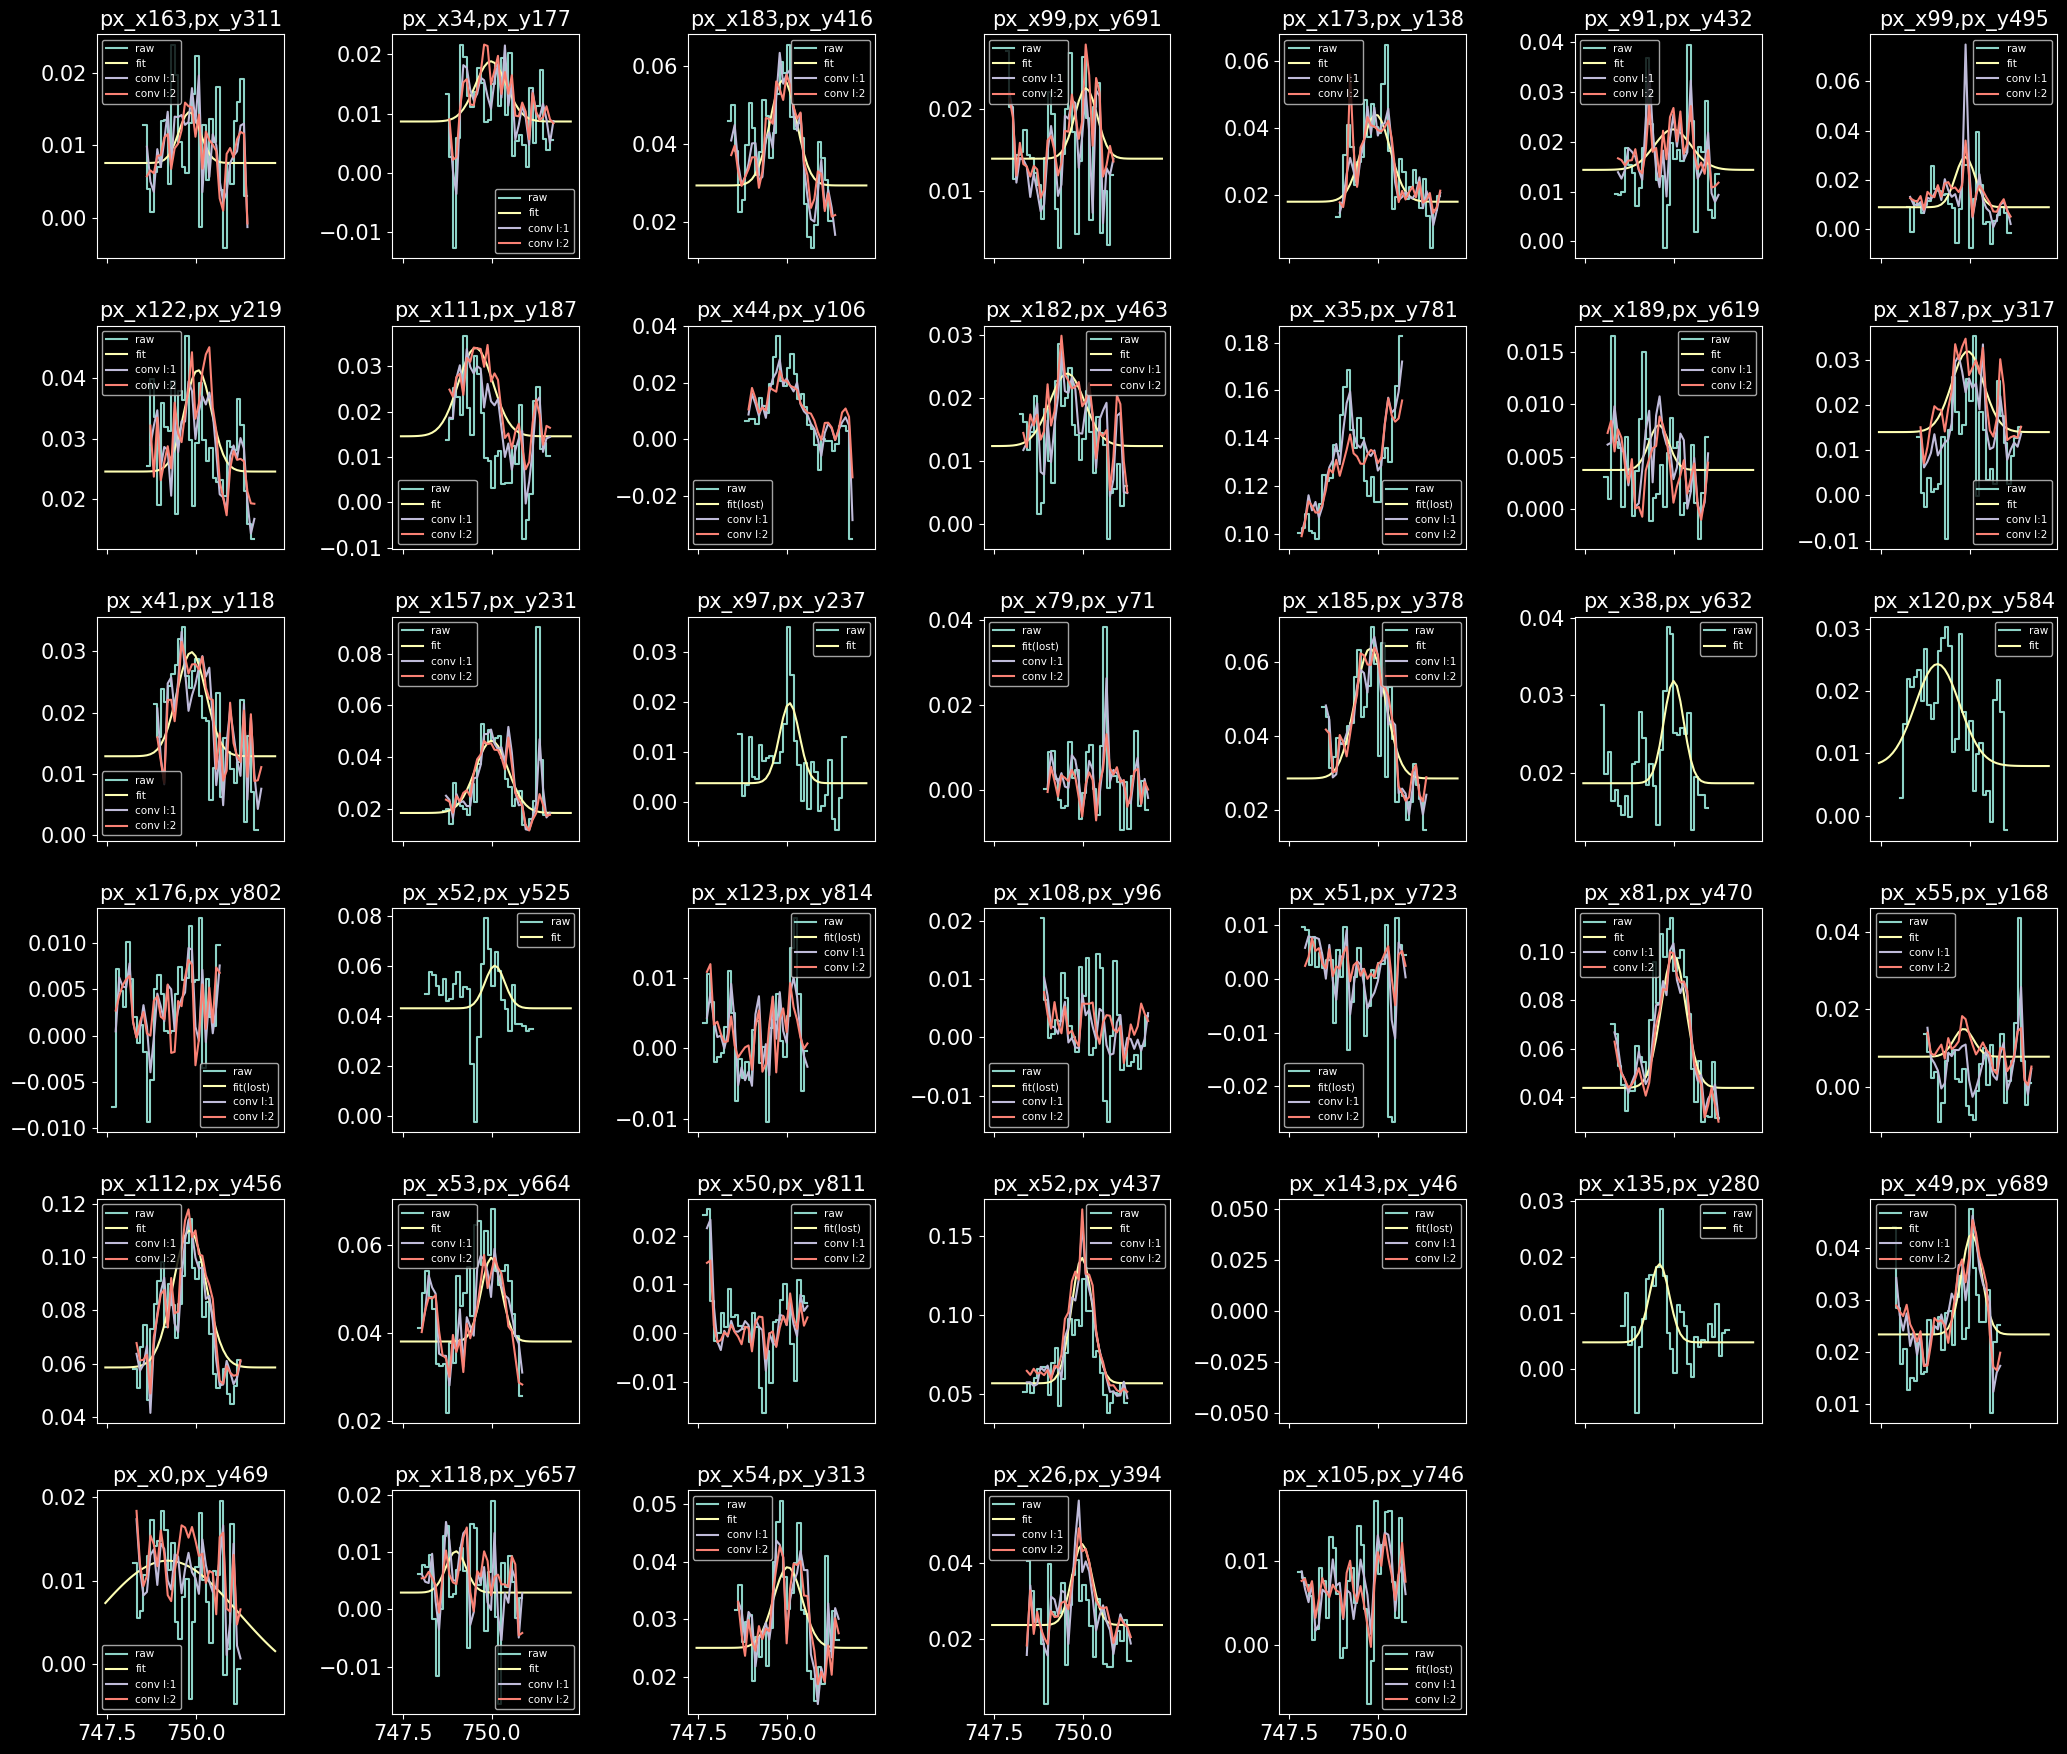

In [35]:
data.plot_random_pixels(kwOri=1,number=40)